<h1>Range of particles</h1>

<p>Copyright (C) 2022 Universidad Politécnica de Madrid</p>
<p>Author: Manuel Cotelo Ferreiro (manuel.cotelo@upm.es)</p>

<h2>0. Define some utilities</h2>

In [1]:
import argparse

import numpy
import scipy.interpolate

import matplotlib.pyplot as plt

units = argparse.Namespace(
    mass = argparse.Namespace(
        amu_to_MeV = 931.49406121e+00,
        kg_to_g = 1.e3,
    ),
    length = argparse.Namespace(
        m_to_cm = 1.e2,
        cm_to_m = 1.e-2,
        m_to_mm = 1.e3,
        mm_to_m = 1.e-3,
        mm_to_cm = 1.e-1,
        cm_to_mm = 1.e1,
    ),
    area = argparse.Namespace(
        mm2_to_cm2 = 1.e-2,
        cm2_to_mm2 = 1.e2,
    ),
    volume = argparse.Namespace(
        m3_to_mm3 = 1.e9,
        m3_to_cm3 = 1.e6,
    ),
    energy = argparse.Namespace(
        eV_to_MeV = 1.e-6,
        MeV_to_eV = 1.e6,
        keV_to_MeV = 1.e-3,
        MeV_to_keV = 1.e3,
    ),
    xs = argparse.Namespace(
        barn_to_cm2 = 1.e-24,
        cm2_to_barn = 1.e24,
    ),
    temperature = argparse.Namespace(
        kelvin_to_eV = 1./11604.,
        kelvin_to_keV = 1./11604.e3,
    ),
)

n_avog = 6.022e23

<h2>1. Load cross sections</h2>

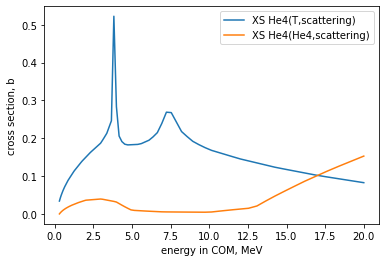

In [2]:
# define file anem with data in CSV format
file_T3 = 'janis/xs_T.csv'
file_He4 = 'janis/xs_He4.csv'

# load data for T
data_T3 = numpy.genfromtxt( file_T3, delimiter=';', )

# load data for He4
data_He4 = numpy.genfromtxt( file_He4, delimiter=';', )

# build an interpolation functor to evaluate the cross section for any energy
func_xs_T = scipy.interpolate.interp1d( data_T3[:,0], data_T3[:,1], bounds_error=False, fill_value=( 0., 0., ), ) # return 0. on extrapolation
func_xs_He4 = scipy.interpolate.interp1d( data_He4[:,0], data_He4[:,1], bounds_error=False, fill_value=( 0., 0., ), ) # return 0. on extrapolation

# create energy mesh
en_lo, en_hi, en_num = 300.e+3, 20.e+6, 100
en = numpy.exp(numpy.linspace(numpy.log(en_lo),numpy.log(en_hi),en_num))

# plot cross section
fig = plt.figure()

plt.xlabel('energy in COM, MeV')
plt.ylabel('cross section, b')

#plt.xscale('log')
#plt.yscale('log')

plt.plot(en*units.energy.eV_to_MeV,func_xs_T(en),label='XS He4(T,scattering)')
plt.plot(en*units.energy.eV_to_MeV,func_xs_He4(en),label='XS He4(He4,scattering)')

plt.legend()

plt.show()

<h2>2. Mean free path</h2>

\begin{align}
\lambda = \frac{1}{n \cdot \sigma(E) }
\end{align}

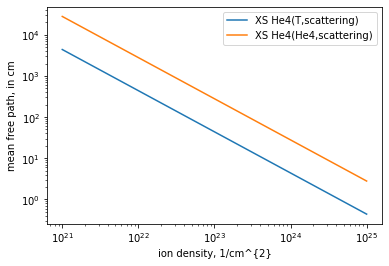

In [3]:
# mean free path, in cm
func_mfp_T   = lambda ni, e: 1./(ni*func_xs_T(e)*units.xs.barn_to_cm2)
func_mfp_He4 = lambda ni, e: 1./(ni*func_xs_He4(e)*units.xs.barn_to_cm2)

# mesh of densities, in 1/cm3
ni_lo, ni_hi, ni_num = 1.e+21, 1.e+25, 100
ni = numpy.exp(numpy.linspace(numpy.log(ni_lo),numpy.log(ni_hi),ni_num))

# energy of the DT fusion alpha particle, in eV
e = 3.5e+6 

# plot results
fig = plt.figure()

plt.xlabel('ion density, 1/cm^{2}')
plt.ylabel('mean free path, in cm')

plt.xscale('log')
plt.yscale('log')

plt.plot(ni,func_mfp_T(ni,e),label='XS He4(T,scattering)')
plt.plot(ni,func_mfp_He4(ni,e),label='XS He4(He4,scattering)')

plt.legend()

plt.show()


<h2>3. Load cross sections from Geant4</h2>

<p>Geant4 is a Monte Carlo particle transport code. It includes cross sections for several processes and materials based on nuclear data tables (from ENDF) of from models. The data used in Geant4 is the mean free path $\lambda$, where  $\Sigma = 1 / \lambda$ is the macroscopic cross section and with $\lambda$ in units of $mm$.</p>

In [4]:
# density of the DT
den = 1. # data is for 1 kg/m3 of DT at 50% in atomic fraction
aw_D = 2.014
aw_T = 3.016
x_D, x_T = 0.5, 0.5
aw_avg = x_D*aw_D + x_T*aw_T
ni = (den*n_avog/aw_avg)*(units.mass.kg_to_g/units.volume.m3_to_mm3)

# file names
file_name_kt = 'geant4/kt.txt'

file_name_elas = 'geant4/info_xs_alpha_proc003.txt'
file_name_inel = 'geant4/info_xs_alpha_proc004.txt'

# load data
kt = numpy.loadtxt(file_name_kt)*units.temperature.kelvin_to_keV

data_elas = numpy.loadtxt(file_name_elas)
data_inel = numpy.loadtxt(file_name_inel)

# reinterpret loaded data, energies are in MeV and macroscopic cross section in cm^2
en_elas, xs_elas = data_elas[:,0], data_elas[:,1:]/units.length.mm_to_cm
en_inel, xs_inel = data_inel[:,0], data_inel[:,1:]/units.length.mm_to_cm

# create an interpolator
func_sigma_elas = scipy.interpolate.interp2d( kt, en_elas, xs_elas/ni, bounds_error=False, fill_value=numpy.nan, )
func_sigma_inel = scipy.interpolate.interp2d( kt, en_inel, xs_inel/ni, bounds_error=False, fill_value=numpy.nan, )

<h2>4. Mean free path for alpha particles</h2>

In [6]:
# define energy of alpha particle, in MeV
kin_alpha = 3.51

# define ion density of the plasma, in 1/cm3
ni = 1.e24

# define temperature of the plasma, in keV
kt = 15.0

# get macroscopic cross sections
xs_elas = ni*func_sigma_elas( kt, kin_alpha, )[0]
xs_inel = ni*func_sigma_inel( kt, kin_alpha, )[0]
xs_tot = xs_elas + xs_inel

print( f'# xs_elas = {xs_elas:15.7e} 1/cm')
print( f'# xs_inel = {xs_inel:15.7e} 1/cm')
print( f'# xs_tot  = {xs_tot:15.7e} 1/cm')

# get free paths
l_tot = 1./xs_tot

print( f'# total mean free path = {l_tot:15.7e} cm ', )

# xs_elas =   5.0930716e+02 1/cm
# xs_inel =   5.7797431e+02 1/cm
# xs_tot  =   1.0872815e+03 1/cm
# total mean free path =   9.1972505e-04 cm 


<h2>5. Escape factor of alpha particles in a sphere</h2>

<p>We can do a small Monte Carlo simulation to compute the fraction of alpha particles that scape some defined volume of plasma, in this case a sphere.</p>
<p>The next block includes a MC simulation to get the amount of alpha particles that scapes a sphere without interation.</p>

In [9]:
# define energy of alpha particle, in MeV
kin_alpha = 3.51

# define ion density of the plasma, in 1/cm3
ni = 1.e15

# define temperature of the plasma, in keV
kt = 15.0

# define sphere
sphere = argparse.Namespace(
    radius = 1.e-3,
    center = numpy.zeros( 3, ),
)

# define spectra of alpha particles
alpha_spec = argparse.Namespace(
    type = 'mono',
    value = kin_alpha,
)

# particle gun, random sampling of initial position of particles and directions
def random_sphere_pos(num):
    r = numpy.power(numpy.random.random(num), 1./3.);
    u = 2.*numpy.random.random(num) - 1
    w = numpy.sqrt(1. - u*u)
    phi = 2.*numpy.pi*numpy.random.random(num)
    xs = numpy.array( [ w*numpy.cos(phi), w*numpy.sin(phi), u, ])
    return r[:,None]*xs.T

def random_sphere_dir(num):
    u = 2.*numpy.random.random(num) - 1
    w = numpy.sqrt(1. - u*u)
    phi = 2.*numpy.pi*numpy.random.random(num)
    xs = numpy.array( [ w*numpy.cos(phi), w*numpy.sin(phi), u, ])
    return xs.T

def gun(num,sphere,alpha_spec):
    return ( sphere.center + sphere.radius*random_sphere_pos(num), 
             random_sphere_dir(num), 
             alpha_spec.value*numpy.ones( num, ), 
             )

# create sample 
num_samples = 10000
pos, dir, ene = gun(num_samples,sphere,alpha_spec)

# transport particle till the edge of the sphere
def cross(x,v,sphere):
    # assume points inside an sphere, then we will have always two solutions, 
    # one forward and other backward, keep forward solution
    
    u = x - sphere.center
    
    b = 2.*numpy.sum( u*v, axis=-1, )
    c = numpy.sum( u*u, axis=-1, ) - sphere.radius*sphere.radius
    
    disc = numpy.sqrt(b*b - 4.*c)
    
    lp = (-b + disc)/2.
    lm = (-b - disc)/2.
    
    return numpy.where( lm < lp, lp, lm, )

# get transport length of particles from current position till sphere edge
ls = cross(pos,dir,sphere)

# get macroscopic cross section
xs_elas = ni*func_sigma_elas( kt, ene, )[...,0]
xs_inel = ni*func_sigma_inel( kt, ene, )[...,0]
xs_tot = xs_elas + xs_inel

# get interaction probabilities
ps = 1. - numpy.exp(-ls/xs_tot)

# get random sample to decide wherther the particle interacts inside the sphere or not
ps_target = numpy.random.random(num_samples)

#print(ps)

# decide
events = numpy.where( ps < ps_target, 1., 0., )

# do stats
num_inside = numpy.sum(events)
num_outside = num_samples - num_inside

print( f'# inside = {num_inside}')

# inside = 4.0
